<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/MinimalDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Barebones Diffusion Model


"Creating noise from data is easy; creating data from noise is generative modeling." (opening line in [1]).  

Imagine a black box that takes in random noise and "generates" samples from an underlying distribution. 

Let's consider a very simple coin toss as a process that generates coin flips with a probability of 0.3 of producing heads. We can describe the underlying probability distribution for this generative process (coin toss) as $p(x)$ where $x\in \{H=1,T=0\}$ is sampled from $p(x)$, i.e., $x\backsim p(x)$. We would like to use a Diffusion Model to model this process using a number of data samples or observations from the original process for training. 

Specifically, we would like to train a generative process such that can generate a series of coin tosses whose probability distribution matches the distribution described above, i.e., $P(H)=0.3, P(T)=0.7$! 

In more mathematical terms, we would like to train a generative model $x=G(z;\theta_G)$ that can generate samples $x$ using Normally distributed random input ($z\backsim N(0,1)$) such that the probability distribution of these generated samples $p_G(x)$ is close to $p(x)$ without knowing $p(x)$ in advance or explicitly modelling $p_G(x)$. 

Using a GAN is an overkill for this simple task and there are much simpler and more effective ways of modelling this simple problem. However, this GAN based solution is intended to help you understand how GANs can model complex densities implicitly and can be used to generate samples that mimic the true or natural generative process. 

We first simulate the coin toss and generate 1024 training samples below. The histogram shows the (sample estimate of) the true density. 

[1] Song, Yang, Jascha Sohl-Dickstein, Diederik P. Kingma, Abhishek Kumar, Stefano Ermon, and Ben Poole. “Score-Based Generative Modeling through Stochastic Differential Equations.” arXiv, February 10, 2021. https://doi.org/10.48550/arXiv.2011.13456.

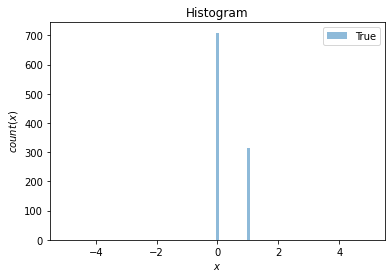

Example Data tensor([[0., 0., 0.,  ..., 0., 1., 1.]])


In [ ]:
"""
A toy GAN to generate coin tosses
"""

# Let's model the natural density and generate some data using that

import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
train_data_length = 1024
def cointoss(t):
  phead = 0.3
  return 1.0*(t<phead)

train_data = torch.zeros((train_data_length, 1))
train_data[:, 0] = cointoss(torch.rand(train_data_length))
bins = np.linspace(-5, 5, 100)
plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.show()
print('Example Data',train_data.T)

Below, we make a generator and a discriminator and train them with a batch size of 32. The generator will produce coin toss results which should have the same probabilities as the original coin and it will learn its weight parameters based on the observations only and its interaction with the discriminator. The generator takes a Gaussian random noise prior as input, i.e., its input is a single Gaussian Random number with mean zero and variance 1.0. It will learn to map this input number to the target variable (heads or tails) by learning the sampling based on given observations. Consequently, our generator is a single input, single output neural network. 

The discriminator will take a random number as input and decide whether it corresponds to fake (generated by the Generator) or real (generated by the real process) coin flip by learning to produce an output of 0.0 for fake and a label of 1.0 for real samples. 

We use binary cross entropy as the loss function in this case. At each training step the discriminator learns to classify real and fake data samples whereas the generator tries to produce samples that match the natural process and can fool the discriminator. For visualization, we plot the current estimate of the histogram after eevry few epochs and compare it to the true density. However, it is important to note that GANs do not explicitly model the density $p(x)$ but rather generate samples $x$ through an implicit modeling of the underlying probability density. 

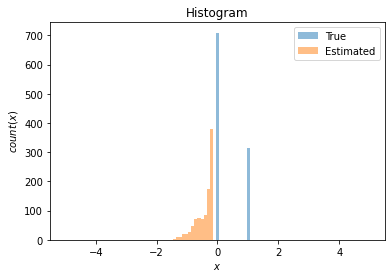

Epoch: 0 Loss D.: 0.6912013292312622
Epoch: 0 Loss G.: 0.6844253540039062


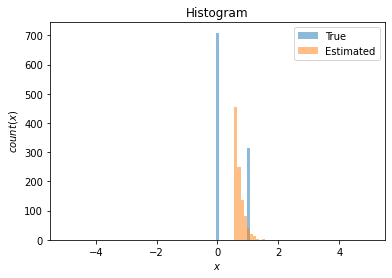

Epoch: 50 Loss D.: 0.7365711331367493
Epoch: 50 Loss G.: 0.6040360331535339


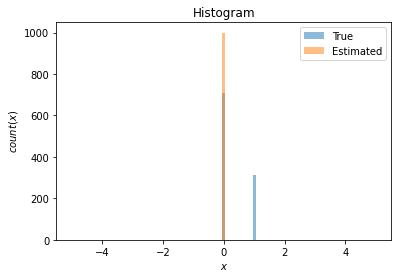

Epoch: 100 Loss D.: 0.6204550266265869
Epoch: 100 Loss G.: 0.8009586930274963


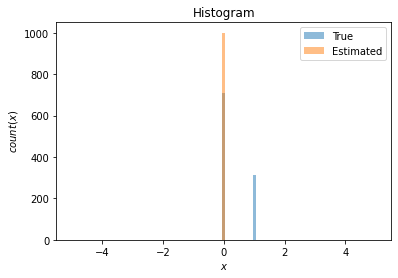

Epoch: 150 Loss D.: 0.622590184211731
Epoch: 150 Loss G.: 0.856653094291687


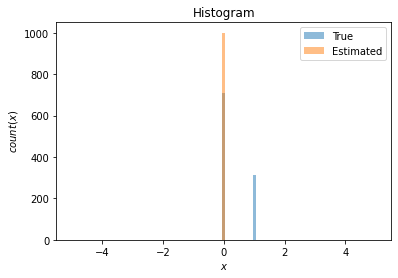

Epoch: 200 Loss D.: 0.6585134267807007
Epoch: 200 Loss G.: 0.8182554841041565


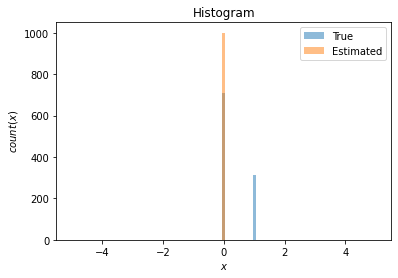

Epoch: 250 Loss D.: 0.6343465447425842
Epoch: 250 Loss G.: 0.8828651905059814


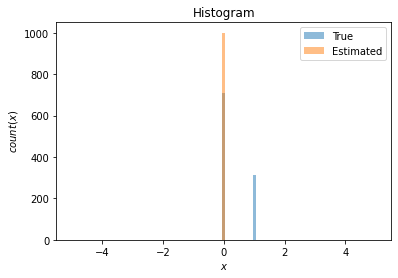

Epoch: 300 Loss D.: 0.6180165410041809
Epoch: 300 Loss G.: 0.8914716243743896


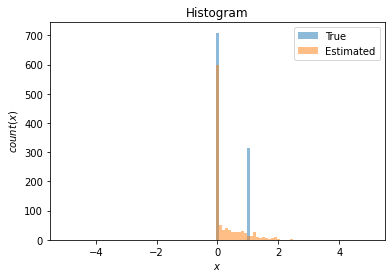

Epoch: 350 Loss D.: 0.67656010389328
Epoch: 350 Loss G.: 0.7469807267189026


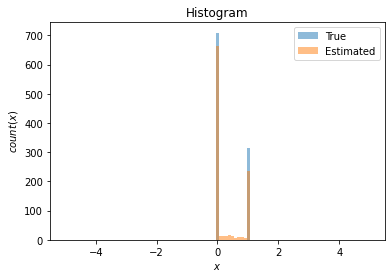

Epoch: 400 Loss D.: 0.6735788583755493
Epoch: 400 Loss G.: 0.7817835211753845


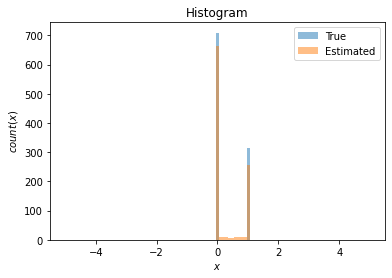

Epoch: 450 Loss D.: 0.6790764331817627
Epoch: 450 Loss G.: 0.7356427907943726


In [ ]:
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)]
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

# Discriminator classifies a given input into real (1) or fake (0)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),            
            nn.Linear(32, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()


#Generator generates a sample using latent random noise factors as input
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
showPlot=True
for epoch in range(num_epochs):
  
    if epoch%50==0 and showPlot:
        latent_space_samples = torch.randn(1000, 1)
        generated_samples = generator(latent_space_samples)
        latent_space_samples = torch.randn(1000, 1).detach()
        generated_samples = generated_samples.detach()
        plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
        plt.hist(generated_samples[:,0],bins=bins,alpha=0.5, label='Estimated')
        plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
        plt.show()


    for n, (real_samples, _) in enumerate(train_loader):
        # Data for descriminator training
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 1))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Discriminator training
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for generator training
        latent_space_samples = torch.randn((batch_size, 1))

        # Generator training
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        

        # Output value of loss function
        if epoch % 50 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

           



Once the GAN has converged, we can generate samples using the generator and plot their histogram and compare it to the true distribution. Notice that the generator is simply mapping a single input (Gaussian random input) into a Heads (1.0) or Tails (0.0) by implicitly modelling the underlying generative process using its interaction with the discriminator. Below, we can see this mapping for the trained GAN. 

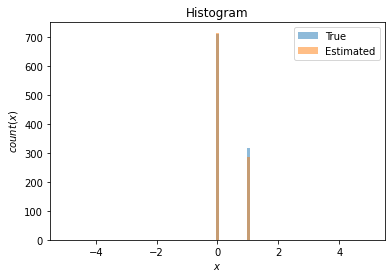

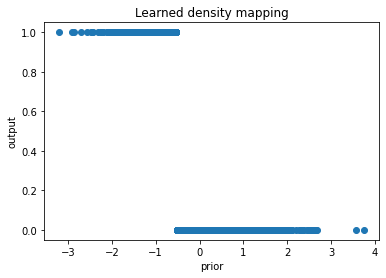

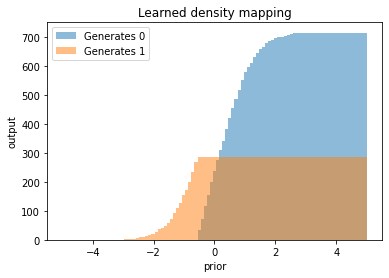

Generated Samples tensor([-0., -0., -0., 0., -0., 1., 1., -0., -0., 0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., 1., 1., -0., -0., -0., -0., -0., -0., 0., -0., -0., 1., 1., -0., -0., -0., 1.,
        -0., -0., -0., -0., -0., -0., -0., 1., 1., -0., -0., -0., -0., -0.])


In [ ]:
plt.figure()
latent_space_samples = torch.randn(1000, 1)
generated_samples = generator(latent_space_samples)
latent_space_samples = latent_space_samples.detach()[:,0]
generated_samples = np.round(generated_samples.detach()[:,0])
plt.hist(train_data[:,0],bins=bins,alpha=0.5, label='True')
plt.hist(generated_samples,bins=bins,alpha=0.5, label='Estimated')
plt.title('Histogram');plt.xlabel('$x$');plt.ylabel('$count(x)$');plt.legend()
plt.figure()
plt.plot(latent_space_samples,generated_samples,'o')
plt.xlabel('prior');plt.ylabel('output');plt.title('Learned density mapping')
plt.figure()
plt.hist(latent_space_samples[generated_samples==0.0],cumulative=True,bins=bins,alpha=0.5, label='Generates 0')
plt.hist(latent_space_samples[generated_samples==1.0],cumulative=True,bins=bins,alpha=0.5, label='Generates 1')
#plt.hist(latent_space_samples,cumulative=True,bins=bins,alpha=0.5, label='Cumulative')
plt.title('Histogram');plt.xlabel('$z$');plt.ylabel('$count(z)$');plt.legend()

plt.xlabel('prior');plt.ylabel('count');plt.title('Learned density mapping')
plt.show()
print('Generated Samples',torch.round(generated_samples[:50].T))

In [ ]:
latent_space_samples[generated_samples==1.0].shape

torch.Size([286])

## Exercise:

See if you can train a model with a diffenrent probability of heads.

See if you can train a GAN to model more complex 1-D density estimation problems. 

See if you can change the loss function and architectures of the generator and discriminator networks to learn the desnsity more efficiently.



### Acknowledgements

Some parts of this tutorial have been inspired from the source below which is strongly recommended for reading.

Raevskiy, Mikhail. “Write Your First Generative Adversarial Network Model on PyTorch.” Medium, August 31, 2020. https://medium.com/dev-genius/write-your-first-generative-adversarial-network-model-on-pytorch-7dc0c7c892c7.
